In [158]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn matplotlib pandas openml

In [159]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
import openml
import sklearn

# Práctica 4: Overfitting

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones. Cada función está marcada por &#x1F625;,  &#x1F643; o &#x1F921;. Las marcas indican:

- &#x1F625;: Indican una entrega que debe ser hecha dentro de la misma sesión de la asignación. 
- &#x1F643;: Indican una entrega que puede ser hecha hasta la siguiente sesión.
- &#x1F921;: Debe mostrar un avance en la misma sesión, pero la entrega puede ser hecha en la siguiente.

Aquellas entregas parciales que no sean hechas el día de la asignación ya no serán válidas para las entregas totales, sin embargo, las entregas totales seguirán siendo válidas.

En esta sección se incluye un dataset real. El dataset importado se llama LDPA y puede leer su descripción en la siguiente liga

https://www.openml.org/d/1483

In [160]:
# Descarga la metadata del dataset
dataset_info = openml.datasets.get_dataset(1483, download_data=False)

# Obtiene el nombre de la columna a predecir
target = dataset_info.default_target_attribute

(
    features, # Dataframe con las características que se pueden utilizar para predecir
    outputs, # Columna a predecir
    categorical_mask, # Máscara que indica que columnas de todas las características son categoricas
    columns # Lista con el nombre de las características
)= dataset_info.get_data(
    dataset_format="dataframe", target=target
)

categorical_mask = np.array(categorical_mask)
columns = np.array(columns)

In [161]:
print(f"La columna a predecir se llama '{target}'")
print(f"Todas las características son {str(columns)}")
print(f"Las características categóricas son {str(columns[categorical_mask])}")
print(f"Las características numéricas son {str(columns[~categorical_mask])}")

La columna a predecir se llama 'Class'
Todas las características son ['V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7']
Las características categóricas son ['V1' 'V2']
Las características numéricas son ['V3' 'V4' 'V5' 'V6' 'V7']


In [162]:
# Impresión de las características
features

,V1,V2,V3,V4,V5,V6,V7
0,1,1,105794.0,105777.0,148933.0,108479.0,109365.0
1,1,4,105795.0,105778.0,155325.0,96952.0,161363.0
2,1,3,105796.0,105779.0,156652.0,101610.0,148870.0
3,1,1,105797.0,105780.0,149736.0,107135.0,102479.0
4,1,2,105798.0,105781.0,155978.0,125455.0,106203.0
...,...,...,...,...,...,...,...
164855,5,2,43687.0,43679.0,106611.0,123166.0,12432.0
164856,5,1,43688.0,43680.0,120821.0,119848.0,87463.0
164857,5,4,43689.0,43681.0,104999.0,110823.0,161536.0
164858,5,2,43690.0,43682.0,102191.0,112520.0,10811.0


In [163]:
outputs

0         3
1         3
2         3
3         3
4         3
         ..
164855    3
164856    3
164857    3
164858    3
164859    3
Name: Class, Length: 164860, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

A continuación se realiza la partición de __train__ y __test__. __No debe utilizar la partición de test por ningún motivo__.

In [164]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    features, 
    outputs, 
    test_size=0.5, 
    random_state=11
)

## Asignación 1 &#x1F921;

Utilizando las técnicas vistas en clase, realicé su mejor esfuerzo para obtener el mejor modelo lineal posible utilizando __únicamente el conjunto de entrenamiento__ (X_train y y_train). Puede utilizar bibliotecas, pero únicamente las técnicas vistas en clase y debe ir generando métricas o visualizaciones que respalden su toma de decisiones. Debe tener e imprimir una estimación de $E_{out}$ utilizando su conjunto de entrenamiento. La métrica utilizada será la entropía cruzada.

## EDA

In [165]:
def check_nans(df):
    for c in list(df.columns.values):
        print(c + ' NaNs -> ' + str(df[c].isnull().sum()))

In [166]:
def plot_hist(column):
    skewness = calc_skewness(column)
    __fig__, __axs__ = plt.subplots(ncols=1, figsize=(15, 5))
    __fig__.subplots_adjust(hspace=0.1, wspace=0.3)
    
    __axs__.set(title="Column (mean = {}, std = {}, skewness = {})".format(round(column.mean(), 2), round(column.std(), 2), round(skewness, 2)))
    _ = sns.histplot(x=column, ax=__axs__)
    _.axvline(x=column.mean(),
                color='blue',
                ls='--', 
                lw=2.5)

In [167]:
def calc_skewness(x):
    return (((x - x.mean()) / (x.var() ** (1/2))) ** 3).mean()

In [168]:
check_nans(X_train)

V1 NaNs -> 0
V2 NaNs -> 0
V3 NaNs -> 0
V4 NaNs -> 0
V5 NaNs -> 0
V6 NaNs -> 0
V7 NaNs -> 0


## Histogramas

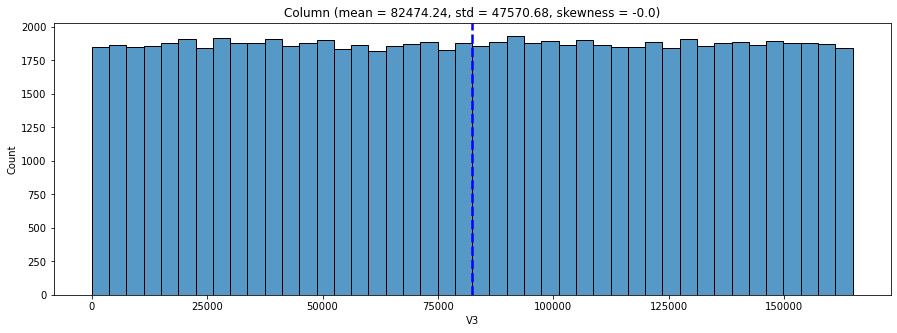

In [169]:
plot_hist(X_train.V3)

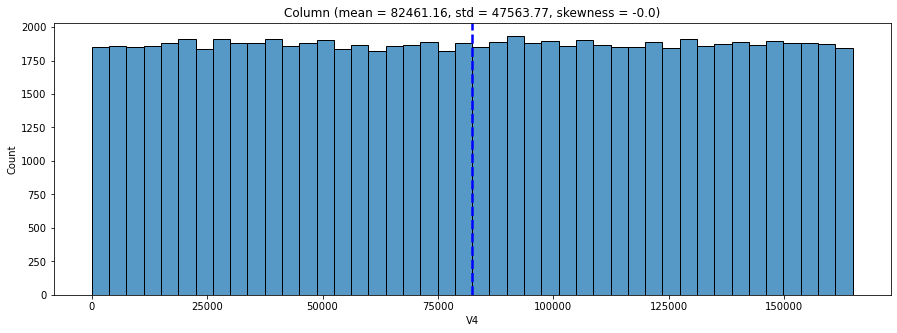

In [170]:
plot_hist(X_train.V4)

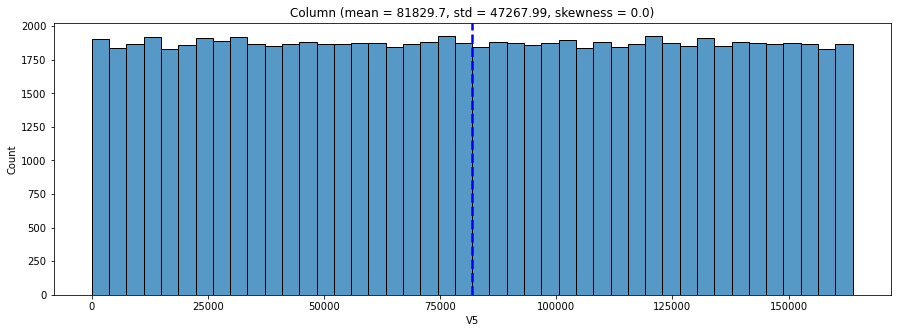

In [171]:
plot_hist(X_train.V5)

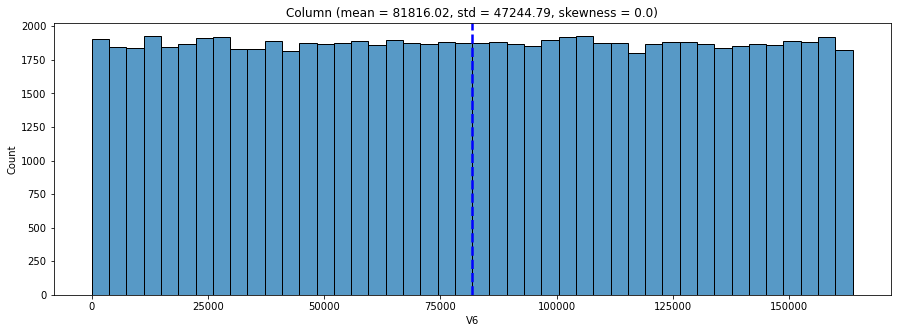

In [172]:
plot_hist(X_train.V6)

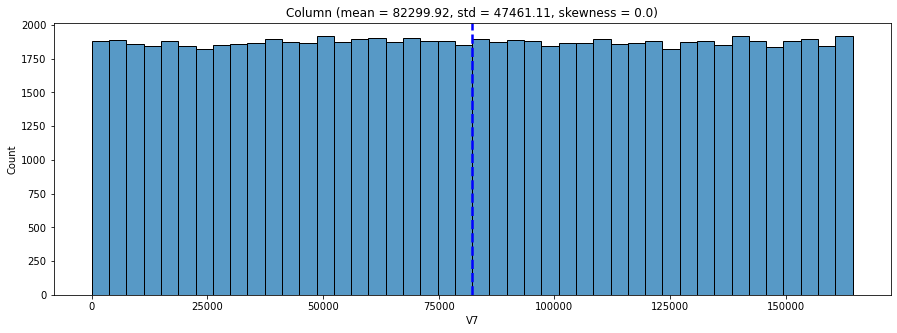

In [173]:
plot_hist(X_train.V7)

Podemos visualizar que las distribuciones de nuestras variables numéricas son prácticamente uniformes.

### Proporción de clases (desbalanceada)

In [174]:
from collections import Counter

In [175]:
count_y_train = dict(sorted(dict(Counter(y_train)).items(), key=lambda x:x[1], reverse=True))
count_y_train

{'4': 27168,
 '3': 16359,
 '7': 13621,
 '10': 9275,
 '9': 5884,
 '5': 3045,
 '6': 2665,
 '1': 1497,
 '2': 1360,
 '8': 852,
 '11': 704}

In [176]:
counts_ls = list(count_y_train.values())

In [177]:
counts_ls_prob = [elem / sum(counts_ls) for elem in counts_ls]

In [178]:
class_ls = list(count_y_train.keys())

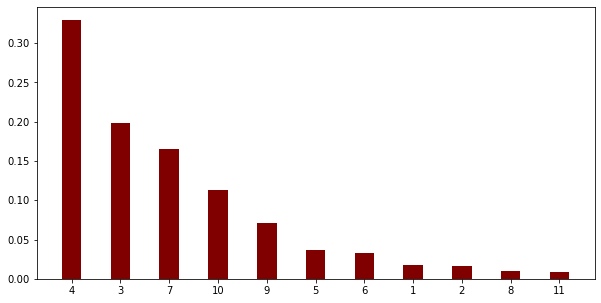

In [179]:
fig = plt.figure(figsize = (10, 5))
plt.bar(class_ls, counts_ls_prob, color ='maroon',
        width = 0.4)
plt.show()

Asimismo podemos observar que las clases a predecir están muy desbalanceadas, lo que probablemente nos generará que el clasificador solo prediga las clases más repetidas, como la 4, 3 y 7.

In [180]:
all_train = pd.concat((X_train, pd.to_numeric(y_train)), axis = 1)
all_train

,V1,V2,V3,V4,V5,V6,V7,Class
82677,3,3,158321.0,158297.0,72476.0,106489.0,146328.0,3
2843,1,1,108637.0,108619.0,135179.0,75851.0,79479.0,10
50670,2,2,98841.0,98825.0,76316.0,137080.0,101775.0,4
128441,5,4,7274.0,7273.0,97161.0,128160.0,137973.0,2
10592,1,2,116386.0,116368.0,70382.0,140689.0,119402.0,4
...,...,...,...,...,...,...,...,...
102327,4,2,56803.0,56792.0,146134.0,114564.0,47575.0,3
97617,4,2,52093.0,52085.0,54989.0,81198.0,26584.0,11
21584,1,1,127378.0,127358.0,44795.0,105412.0,49255.0,3
36543,2,2,84714.0,84700.0,59207.0,33106.0,114460.0,3


In [181]:
corr = all_train.corr()
corr.style.background_gradient(cmap = 'YlOrRd')

,V3,V4,V5,V6,V7,Class
V3,1.000000,1.000000,-0.090484,-0.022801,0.026448,0.022978
V4,1.000000,1.000000,-0.090482,-0.022802,0.026448,0.022979
V5,-0.090484,-0.090482,1.000000,-0.366917,0.026174,0.072940
V6,-0.022801,-0.022802,-0.366917,1.000000,0.013580,-0.095771
V7,0.026448,0.026448,0.026174,0.013580,1.000000,0.010421
Class,0.022978,0.022979,0.072940,-0.095771,0.010421,1.000000


In [182]:
#sns.pairplot(all_train, hue = 'Class', diag_kind='kde')

### Kmeans para generar columna adicional

Por mera experimentación, realizaremos un clustering para poder generar una columna adicional donde se incluye la etiqueta del cluster a la que un determinado registro pertenece, esto para intentar ayudar a que el modelo pueda clasificar de una mejor forma.

In [183]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [184]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_train)
    distortions.append(kmeanModel.inertia_)

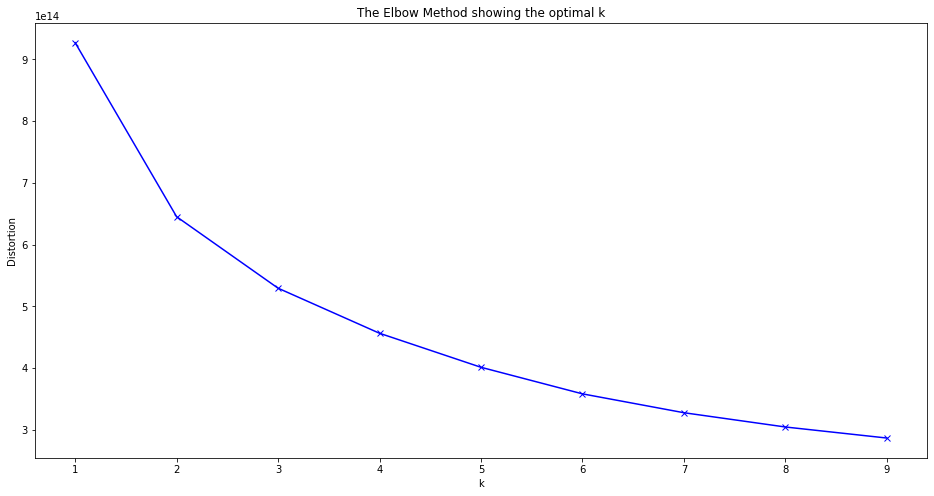

In [185]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Con el gráfico del codo, observamos que la cantidad de cluster sugeridos es de 2. Por lo que procedemos a implementar un KMeans con el conjunto de entrenamiento.

In [186]:
k_opt = 2

In [187]:
km = KMeans(
    n_clusters=k_opt, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

Una vez entrenado el modelo de agrupamiento, predecimos y añadimos etiqueta del cluster a los datos de entrenamiento.

In [188]:
y_km_train = km.fit_predict(X_train)

In [189]:
indexes_train = X_train.index.values

In [190]:
y_km_train_df = pd.DataFrame(y_km_train, columns = ['cluster']).set_index(indexes_train, drop=True, append=False, inplace=False, verify_integrity=False)

In [191]:
X_train = pd.concat((X_train, y_km_train_df), axis = 1)
X_train

,V1,V2,V3,V4,V5,V6,V7,cluster
82677,3,3,158321.0,158297.0,72476.0,106489.0,146328.0,1
2843,1,1,108637.0,108619.0,135179.0,75851.0,79479.0,1
50670,2,2,98841.0,98825.0,76316.0,137080.0,101775.0,1
128441,5,4,7274.0,7273.0,97161.0,128160.0,137973.0,0
10592,1,2,116386.0,116368.0,70382.0,140689.0,119402.0,1
...,...,...,...,...,...,...,...,...
102327,4,2,56803.0,56792.0,146134.0,114564.0,47575.0,0
97617,4,2,52093.0,52085.0,54989.0,81198.0,26584.0,0
21584,1,1,127378.0,127358.0,44795.0,105412.0,49255.0,1
36543,2,2,84714.0,84700.0,59207.0,33106.0,114460.0,1


Análogamente, hacemos lo mismo en los datos de prueba. Cabe mencionar que no estamos alterando el contenido original de los datos de prueba, ya que solamente le estamos agregando una columna que igual colocamos en el entrenamiento.

In [192]:
y_km_test = km.fit_predict(X_test)

In [193]:
indexes_test = X_test.index.values

In [194]:
y_km_test_df = pd.DataFrame(y_km_test, columns = ['cluster']).set_index(indexes_test, drop=True, append=False, inplace=False, verify_integrity=False)

In [195]:
X_test = pd.concat((X_test, y_km_test_df), axis = 1)
X_test

,V1,V2,V3,V4,V5,V6,V7,cluster
9783,1,4,115577.0,115559.0,90402.0,18088.0,121817.0,0
85013,3,4,160657.0,160632.0,5651.0,148068.0,64938.0,0
70883,3,1,146527.0,146506.0,27276.0,100859.0,115620.0,0
64466,3,2,140110.0,140090.0,17717.0,63955.0,11320.0,0
82448,3,4,158092.0,158068.0,399.0,161841.0,163997.0,0
...,...,...,...,...,...,...,...,...
102897,4,1,57373.0,57362.0,64919.0,55294.0,68753.0,1
40732,2,2,88903.0,88889.0,34335.0,31755.0,72117.0,0
114945,4,3,69421.0,69407.0,23650.0,37747.0,133916.0,1
19389,1,2,125183.0,125165.0,123080.0,18023.0,89884.0,0


## Preprocesamiento

In [196]:
import copy

In [197]:
X_train_pp = copy.deepcopy(X_train)
X_train_pp

,V1,V2,V3,V4,V5,V6,V7,cluster
82677,3,3,158321.0,158297.0,72476.0,106489.0,146328.0,1
2843,1,1,108637.0,108619.0,135179.0,75851.0,79479.0,1
50670,2,2,98841.0,98825.0,76316.0,137080.0,101775.0,1
128441,5,4,7274.0,7273.0,97161.0,128160.0,137973.0,0
10592,1,2,116386.0,116368.0,70382.0,140689.0,119402.0,1
...,...,...,...,...,...,...,...,...
102327,4,2,56803.0,56792.0,146134.0,114564.0,47575.0,0
97617,4,2,52093.0,52085.0,54989.0,81198.0,26584.0,0
21584,1,1,127378.0,127358.0,44795.0,105412.0,49255.0,1
36543,2,2,84714.0,84700.0,59207.0,33106.0,114460.0,1


In [198]:
X_test_pp = copy.deepcopy(X_test)
X_test_pp

,V1,V2,V3,V4,V5,V6,V7,cluster
9783,1,4,115577.0,115559.0,90402.0,18088.0,121817.0,0
85013,3,4,160657.0,160632.0,5651.0,148068.0,64938.0,0
70883,3,1,146527.0,146506.0,27276.0,100859.0,115620.0,0
64466,3,2,140110.0,140090.0,17717.0,63955.0,11320.0,0
82448,3,4,158092.0,158068.0,399.0,161841.0,163997.0,0
...,...,...,...,...,...,...,...,...
102897,4,1,57373.0,57362.0,64919.0,55294.0,68753.0,1
40732,2,2,88903.0,88889.0,34335.0,31755.0,72117.0,0
114945,4,3,69421.0,69407.0,23650.0,37747.0,133916.0,1
19389,1,2,125183.0,125165.0,123080.0,18023.0,89884.0,0


### OneHotEncoding

Codificamos las columnas V1, V2 y cluster ya que son de caracter categórico, tanto en el conjunto de entrenamiento como de prueba.

In [200]:
def ohe(df, columns):
    for col in columns:
        #print(col)
        col_encoded = pd.get_dummies(pd.Series(df[col]))
        #print(col_encoded.head(3))
        df[['{}_'.format(col) + str(c) for c in list(col_encoded.columns.values)]] = col_encoded
        df = df.drop(columns = col)
        
    return df

In [201]:
#cols_to_encode = ['V1', 'V2', 'cluster']
cols_to_encode = ['V1', 'V2']

In [202]:
X_train_ohe = ohe(copy.deepcopy(X_train_pp), cols_to_encode)

In [203]:
X_train_ohe

,V3,V4,V5,V6,V7,cluster,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
82677,158321.0,158297.0,72476.0,106489.0,146328.0,1,0,0,1,0,0,0,0,1,0
2843,108637.0,108619.0,135179.0,75851.0,79479.0,1,1,0,0,0,0,1,0,0,0
50670,98841.0,98825.0,76316.0,137080.0,101775.0,1,0,1,0,0,0,0,1,0,0
128441,7274.0,7273.0,97161.0,128160.0,137973.0,0,0,0,0,0,1,0,0,0,1
10592,116386.0,116368.0,70382.0,140689.0,119402.0,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,56803.0,56792.0,146134.0,114564.0,47575.0,0,0,0,0,1,0,0,1,0,0
97617,52093.0,52085.0,54989.0,81198.0,26584.0,0,0,0,0,1,0,0,1,0,0
21584,127378.0,127358.0,44795.0,105412.0,49255.0,1,1,0,0,0,0,1,0,0,0
36543,84714.0,84700.0,59207.0,33106.0,114460.0,1,0,1,0,0,0,0,1,0,0


In [204]:
X_test_ohe = ohe(copy.deepcopy(X_test_pp), cols_to_encode)

In [205]:
X_test_ohe

,V3,V4,V5,V6,V7,cluster,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
9783,115577.0,115559.0,90402.0,18088.0,121817.0,0,1,0,0,0,0,0,0,0,1
85013,160657.0,160632.0,5651.0,148068.0,64938.0,0,0,0,1,0,0,0,0,0,1
70883,146527.0,146506.0,27276.0,100859.0,115620.0,0,0,0,1,0,0,1,0,0,0
64466,140110.0,140090.0,17717.0,63955.0,11320.0,0,0,0,1,0,0,0,1,0,0
82448,158092.0,158068.0,399.0,161841.0,163997.0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102897,57373.0,57362.0,64919.0,55294.0,68753.0,1,0,0,0,1,0,1,0,0,0
40732,88903.0,88889.0,34335.0,31755.0,72117.0,0,0,1,0,0,0,0,1,0,0
114945,69421.0,69407.0,23650.0,37747.0,133916.0,1,0,0,0,1,0,0,0,1,0
19389,125183.0,125165.0,123080.0,18023.0,89884.0,0,1,0,0,0,0,0,1,0,0


In [206]:
all_train_aux = pd.concat((X_train_ohe, pd.to_numeric(y_train)), axis = 1)
all_train_aux

,V3,V4,V5,V6,V7,cluster,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class
82677,158321.0,158297.0,72476.0,106489.0,146328.0,1,0,0,1,0,0,0,0,1,0,3
2843,108637.0,108619.0,135179.0,75851.0,79479.0,1,1,0,0,0,0,1,0,0,0,10
50670,98841.0,98825.0,76316.0,137080.0,101775.0,1,0,1,0,0,0,0,1,0,0,4
128441,7274.0,7273.0,97161.0,128160.0,137973.0,0,0,0,0,0,1,0,0,0,1,2
10592,116386.0,116368.0,70382.0,140689.0,119402.0,1,1,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,56803.0,56792.0,146134.0,114564.0,47575.0,0,0,0,0,1,0,0,1,0,0,3
97617,52093.0,52085.0,54989.0,81198.0,26584.0,0,0,0,0,1,0,0,1,0,0,11
21584,127378.0,127358.0,44795.0,105412.0,49255.0,1,1,0,0,0,0,1,0,0,0,3
36543,84714.0,84700.0,59207.0,33106.0,114460.0,1,0,1,0,0,0,0,1,0,0,3


In [207]:
corr = all_train_aux.corr()
corr.style.background_gradient(cmap = 'YlOrRd')

,V3,V4,V5,V6,V7,cluster,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class
V3,1.000000,1.000000,-0.090484,-0.022801,0.026448,0.865593,0.348591,0.082454,0.681504,-0.234264,-0.764943,-0.030277,0.004961,-0.031910,0.061016,0.022978
V4,1.000000,1.000000,-0.090482,-0.022802,0.026448,0.865597,0.348591,0.082450,0.681512,-0.234276,-0.764936,-0.030278,0.004961,-0.031910,0.061016,0.022979
V5,-0.090484,-0.090482,1.000000,-0.366917,0.026174,-0.069029,0.012489,-0.027603,-0.049416,-0.047763,0.100362,0.055597,0.003832,0.004071,-0.067802,0.072940
V6,-0.022801,-0.022802,-0.366917,1.000000,0.013580,-0.062139,-0.052831,-0.027282,0.018800,0.026907,0.027725,0.050244,-0.016560,-0.021568,-0.013143,-0.095771
V7,0.026448,0.026448,0.026174,0.013580,1.000000,0.055539,0.056914,0.023734,-0.007802,-0.051150,-0.016214,-0.264878,-0.284447,0.240240,0.329748,0.010421
cluster,0.865593,0.865597,-0.069029,-0.062139,0.055539,1.000000,0.440215,0.291702,0.479048,-0.496362,-0.611072,-0.025955,-0.001953,-0.019904,0.050976,0.033639
V1_1,0.348591,0.348591,0.012489,-0.052831,0.056914,0.440215,1.000000,-0.212044,-0.217959,-0.218642,-0.269003,-0.036018,-0.050092,0.023046,0.067200,0.012054
V1_2,0.082454,0.082450,-0.027603,-0.027282,0.023734,0.291702,-0.212044,1.000000,-0.230749,-0.231471,-0.284788,0.023240,0.003547,-0.001791,-0.026694,0.015636
V1_3,0.681504,0.681512,-0.049416,0.018800,-0.007802,0.479048,-0.217959,-0.230749,1.000000,-0.237929,-0.292732,-0.009343,0.025139,-0.044736,0.030849,0.012094
V1_4,-0.234264,-0.234276,-0.047763,0.026907,-0.051150,-0.496362,-0.218642,-0.231471,-0.237929,1.000000,-0.293649,-0.016103,0.009315,0.015817,-0.009517,-0.035401


In [208]:
all_train_aux

,V3,V4,V5,V6,V7,cluster,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class
82677,158321.0,158297.0,72476.0,106489.0,146328.0,1,0,0,1,0,0,0,0,1,0,3
2843,108637.0,108619.0,135179.0,75851.0,79479.0,1,1,0,0,0,0,1,0,0,0,10
50670,98841.0,98825.0,76316.0,137080.0,101775.0,1,0,1,0,0,0,0,1,0,0,4
128441,7274.0,7273.0,97161.0,128160.0,137973.0,0,0,0,0,0,1,0,0,0,1,2
10592,116386.0,116368.0,70382.0,140689.0,119402.0,1,1,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,56803.0,56792.0,146134.0,114564.0,47575.0,0,0,0,0,1,0,0,1,0,0,3
97617,52093.0,52085.0,54989.0,81198.0,26584.0,0,0,0,0,1,0,0,1,0,0,11
21584,127378.0,127358.0,44795.0,105412.0,49255.0,1,1,0,0,0,0,1,0,0,0,3
36543,84714.0,84700.0,59207.0,33106.0,114460.0,1,0,1,0,0,0,0,1,0,0,3


In [209]:
#sns.pairplot(all_train_aux, hue = 'Class', diag_kind='kde')

### Borramos columnas (prueba)

In [210]:
#X_train_ohe = X_train_ohe.drop(columns = ['V3', 'V4', 'V1_1', 'V1_2', 'V1_3', 'V1_4', 'V1_5', 'V2_1', 'V2_2', 'V2_3', 'V2_4'])
X_train_ohe = X_train_ohe.drop(columns = ['V3', 'V4'])

### Estandarizamos

Estandarizamos nuestras columnas, con el fin de facilitar el aprendizaje del modelo.

In [199]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_features(X_train, X_test, to_scale):
    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    scaler.fit(X_train[to_scale])
    train_scaled = scaler.transform(X_train[to_scale])
    test_scaled = scaler.transform(X_test[to_scale])
    
    return train_scaled, test_scaled

In [211]:
begin = 0
#end = -k_opt
end = len(X_train_ohe.columns.values)

In [212]:
list(X_train_ohe.columns.values)[begin:end]

['V5',
 'V6',
 'V7',
 'cluster',
 'V1_1',
 'V1_2',
 'V1_3',
 'V1_4',
 'V1_5',
 'V2_1',
 'V2_2',
 'V2_3',
 'V2_4']

In [213]:
cols_to_scale = list(X_train_ohe.columns.values)[begin:end]

In [214]:
X_train_model, X_test_model = scale_features(copy.deepcopy(X_train_ohe), copy.deepcopy(X_test_ohe), cols_to_scale)

In [215]:
X_train_model

array([[0.44246572, 0.65055471, 0.88962792, ..., 0.        , 1.        ,
        0.        ],
       [0.82527259, 0.46338156, 0.48320161, ..., 0.        , 0.        ,
        0.        ],
       [0.46590923, 0.83744074, 0.61875608, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.27347098, 0.64397512, 0.29944674, ..., 0.        , 0.        ,
        0.        ],
       [0.3614574 , 0.20224451, 0.69587792, ..., 1.        , 0.        ,
        0.        ],
       [0.31630423, 0.98020014, 0.50377554, ..., 0.        , 0.        ,
        0.        ]])

In [216]:
y_train_model = copy.deepcopy(y_train)
y_train_model

82677      3
2843      10
50670      4
128441     2
10592      4
          ..
102327     3
97617     11
21584      3
36543      3
141209     4
Name: Class, Length: 82430, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

In [217]:
y_test_model = copy.deepcopy(y_test)
y_test_model

9783       9
85013      4
70883      7
64466      7
82448      4
          ..
102897    10
40732      7
114945    10
19389      4
155502     4
Name: Class, Length: 82430, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

## Modelado y estimación de Error out (validación cruzada)

In [218]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss

### Balanceo de clases (opcional)

In [219]:
#!pip install imblearn

In [220]:
#from imblearn.over_sampling import SMOTE # Library to Balance Dataset
#smote = SMOTE()
#X_train_model, y_train_model = smote.fit_resample(X_train_model, y_train) # Balancing our Data
#X_train_model, y_train_model # Checking our new shape after Over_Sampling

In [221]:
#from imblearn.under_sampling import RandomUnderSampler
#rus = RandomUnderSampler()
#X_train_model, y_train_model = rus.fit_resample(X_train_model, y_train)
#print('Resampled dataset shape %s' % Counter(y_train_model))
#X_train_model, y_train_model # Checking our new shape after Over_Sampling

### Automatización de validación cruzada para cierto modelo

In [222]:
def train_model(model, model_name, x_tr, y_tr, scoring):
    print(model_name)
    
    # Fitting model
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_validate(model, x_tr, y_tr, cv=kfold, scoring=scoring)
    #print(cv_results)
    
    for i in range(len(scoring)):
        sc = scoring[i]
        msg = "Estimation of E_out (%s): %f (%f)" % (sc, cv_results['test_' + sc].mean(), cv_results['test_' + sc].std())
        print(msg)
        print(cv_results['test_' + sc], '\n')

### Regresión logística

In [223]:
model_lr = linear_model.LogisticRegression(penalty = 'l2', max_iter = 1000, verbose = True)
model_name = 'Logistic Regression'
scoring = ['accuracy', 'neg_log_loss']
#scoring = ['accuracy']
train_model(model_lr, model_name, X_train_model, y_train_model, scoring)

Logistic Regression


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimation of E_out (accuracy): 0.392527 (0.004057)
[0.38784423 0.39409196 0.39542642 0.38766226 0.39761009] 

Estimation of E_out (neg_log_loss): -1.688670 (0.007004)
[-1.68840322 -1.69526975 -1.6821995  -1.69767708 -1.67979945] 



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.7s finished


In [224]:
model_lr.fit(X_train_model, y_train_model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.1s finished


LogisticRegression(max_iter=1000, verbose=True)

### Clasificador SGD

In [225]:
model_sgd_lr = linear_model.SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-5)
model_name = 'SGD Classifier'
scoring = ['accuracy', 'neg_log_loss']
train_model(model_sgd_lr, model_name, X_train_model, y_train_model, scoring)

SGD Classifier
Estimation of E_out (accuracy): 0.396955 (0.006230)
[0.39111974 0.40052165 0.40179546 0.38790489 0.40343322] 

Estimation of E_out (neg_log_loss): -1.691443 (0.006599)
[-1.68943656 -1.69712146 -1.6858224  -1.70101906 -1.68381394] 



In [226]:
model_sgd_lr.fit(X_train_model, y_train_model)

SGDClassifier(loss='log', tol=1e-05)

## Asignación 2 &#x1F921;

Evalue su modelo final en el conjunto de test (X_test y y_test). Su práctica será evaluada acorde a las técnicas aplicadas, la estimación de $E_{out}$, el valor de $E_{test}$, y contra las métricas obtenidas por sus compañeros.

## Cálculo de Error test

### Regresión logística

In [227]:
# Predicting
pred_probs = model_lr.predict_proba(X_test_model)
pred = model_lr.predict(X_test_model)

In [228]:
# Scores
acc = accuracy_score(y_test_model, pred) * 100
log_losss = log_loss(y_test_model, pred_probs)
print('accuracy_score', acc, '\nlog_loss_score', log_losss)

accuracy_score 37.03627320150431 
log_loss_score 1.7155650908990028


In [229]:
# Classification Report
print('Classification Report')
print(classification_report(y_test_model, pred))

Classification Report


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1476
          10       0.00      0.00      0.00      9086
          11       0.00      0.00      0.00       677
           2       0.00      0.00      0.00      1488
           3       0.31      0.27      0.28     16351
           4       0.39      0.74      0.51     27312
           5       0.00      0.00      0.00      3123
           6       0.19      0.09      0.13      2545
           7       0.39      0.33      0.36     13623
           8       0.00      0.00      0.00       854
           9       0.33      0.18      0.23      5895

    accuracy                           0.37     82430
   macro avg       0.15      0.15      0.14     82430
weighted avg       0.28      0.37      0.31     82430



C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Clasificador SGD

In [230]:
# Predicting
pred_probs = model_sgd_lr.predict_proba(X_test_model)
pred = model_sgd_lr.predict(X_test_model)

In [231]:
# Scores
acc = accuracy_score(y_test_model, pred) * 100
log_losss = log_loss(y_test_model, pred_probs)
print('accuracy_score', acc, '\nlog_loss_score', log_losss)

accuracy_score 38.137813902705325 
log_loss_score 1.7091893224681312


In [232]:
# Classification Report
print('Classification Report')
print(classification_report(y_test_model, pred))

Classification Report


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1476
          10       0.00      0.00      0.00      9086
          11       0.00      0.00      0.00       677
           2       0.00      0.00      0.00      1488
           3       0.32      0.29      0.30     16351
           4       0.39      0.78      0.52     27312
           5       0.00      0.00      0.00      3123
           6       0.22      0.08      0.11      2545
           7       0.41      0.32      0.36     13623
           8       0.00      0.00      0.00       854
           9       0.41      0.15      0.22      5895

    accuracy                           0.38     82430
   macro avg       0.16      0.15      0.14     82430
weighted avg       0.30      0.38      0.31     82430



C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [233]:
#sklearn.metrics.SCORERS.keys()

In [234]:
#sklearn.metrics.log_loss